# Clustering

<img src="images/clusters.png" width="700">

This lecture will cover basic considerations and concepts in clustering data, and introduce a few basic classes of algorithms along with examples.

* Clustering basics
    - Problem statement for clustering
    - Types of clustering problems/algorithms
    - Accuracy and distance metrics
* Expectation-Maximization models
    - k-means and vector quantization
    - Gaussian mixture models
* Density-based models
    - Mean shift
    - DBSCAN
* Hierarchical clustering
    - Dendrograms
    - Agglomerative clustering
* Conclusions

## Clustering basics

### Problem statement

Clustering algorithms seek to identify data points that are similar to each other based on a set of descriptive features.

Clustering algorithms are **unsupervised** since they do not include output labels. This is an example of **exploratory data analysis** in which the goal is to extract insight about the dataset based on its inherent structure, rather than to build a model that predicts an output. These algorithms can be used for data compression, group assignment, searching, and/or model evaluation or feature extraction for supervised models.

### Types of problems/algorithms

There are a few key types of clustering algorithms:

**Expectation-maximization** algorthims iteratively compute "expected" clusters and then "maximize" the parameters of the cluster to optimize the expectations. This is somewhat similar to an iterative version of a generalized linear classification algorithm: "classes" are assigned, then boundaries are found to optimize a cost function based on these classes. After this optimization the new class boundaries are used to assign classes again, and the optimization is repeated with new "class" labels.

**Density-based** algorithms utilize local information about data points to identify regions where the data has similar density. Regions where there is substantially lower density of data form boundaries between these clusters. This is somewhat similar to k-nearest neighbors where classes are defined by local environments.

**Hierarchical** algorithms map out the full network of connectivity within a dataset, then use a variable distance cutoff to assign clusters. These algorithms can be understood visually through a dendrogram, and have relatively few hyperparameters but they are more computationally demanding.

A few considerations when selecting a clustering algorithm:

* Some algorithms requre defining the number of clusters explicitly (e.g. most expectation-maximization algorithms) while others find this implicitly based on choice of hyperparameters (e.g. density-based or hierarchical)

* Some algorithms allow **mixed membership** where points can belong to multiple clusters based on probabilities.

* Some algorithms can identify/ignore outliers/noise (e.g. density-based), while others attempt to assign clusters to all points (e.g. expectation-maximization and hierarchical).

### Accuracy and distance metrics

Computing the accuracy of unsupervised models is difficult because there is no "right answer". However, it is possible to compute some quantitative metrics based on the concept of a cluster.

* **Silhouette score** is defined for *each point* and is related to two distances:
    - $a$ is the average distance between a point and all other points in its cluster
    - $b$ is the average distance between a point and the points in the next nearest cluster
    - $S = \frac{b-a}{max(a,b)}$ is the silhoutte score
    - $S = -1$ implies totally incorrect, $S=1$ implies totally correct
    - Works best for dense, well-separated clusters
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
The silhouette score can help identify individual points that are not well-clustered, or an average/max silhouette score can be used to evaluate the quality of the entire clustering model. Other metrics can be used to evaluate the overall model:

* **Variance ratio criterion** or "Calinski-Harabaz score" is related to the "within class" variance (similar to intra-class variance for classificaiton) and the "between class" variance (similar to the interclass variance for classification). The mathematical definition is available [here](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101) but is beyond the scope of this course.
    - Variance ratio will be higher for dense and well-separated clusters
    - Not bounded so it can be difficult to know what is "good" and what is "bad"
    - Does not work well for density-based clusters (e.g. DBSCAN)
    
These approaches can be utilized to identify hyperparameters such as the number of clusters in the case where there is no *a priori* expectation about the number of clusters.

Another common technique is to use clustering for classification problems. In this case the error metrics from classification can be applied (e.g. confusion matrices, precision, recall, etc.). The comparison of clustering and classification can provide insight into how well the classes are captured by proximity in the feature space.

Finally, it is worth noting that essentially all clustering algorithms rely on some form of **distance metric**. The way that distance is defined can have substantial impact on how clustering analyses perform. Some common choices to compute the distance between two points $i$ and $j$:

* Euclidean distance ($L_2$ norm): $D_{ij} = \sqrt{sum((\vec{x}_i - \vec{x}_j)^2)}$
* Manhattan distance ($L_1$ norm): $D_{ij} = sum(abs(\vec{x}_i - \vec{x}_j))$
* Chebyshev distance ($L_\infty$ norm): $D_{ij} = max(abs(\vec{x}_i - \vec{x}_j))$
* Minkowsky distance ($L_P$ norm): $D_{ij} = (sum((\vec{x}_i - \vec{x}_j)^P)^{1/P}$

It is also possible to define a weighted distance metric that can implicitly standardize the data, or weight nearby points much higher than far away points. An example is the Mahalanobis distance:

* Mahalanobis distance: $D_{ij} = (\vec{x}_i - \vec{\mu})^T \underline{\underline{C}}^{-1} (\vec{x}_j - \vec{\mu})$
    - $\mu$ is the mean vector
    - $\underline{\underline{C}}$ is the covariance matrix
    
   
* Kernel distance: $D_{ij} = (\vec{x}_i)^T \underline{\underline{K}} (\vec{x}_j)$
    - $\underline{\underline{K}}$ is a kernel-based weight matrix

For simplicity we will typically default to Euclidean distance in most examples; however, changing distance metrics can substantially improve performance in real problems so it is worthwhile to experiment. This is usually as simple as changing a keyword for `scikit-learn` models, or writing a short function to compute the necessary distance.

It is also useful to consider the **cophenetic correlation coefficient** when dealing with different distance metrics or "linkages" in hierarchical representations of high-dimensional data. This can be considered as a comparison between distance metrics and the Euclidean distance. This will be discussed more later.

## Expectation-maximization models

### k-means

The k-means algorithm is the simplest and most intuitive clustering algorithm. It performs remarkably well under a number of assumptions:

* Number of clusters are known
* Clusters are roughly spherical
* Clusters are separated by linear boundaries

Even if these assumptions are violated, it often works anyway, especially in high dimensions (the "blessing" of dimensionality).

The k-means algorithm works using the principal of **expectation-maximization**. This is an iterative type of algorithm that contains two basic steps:

* Expectation: Assign points based on some "expectation" metric.
* Maximization: Revise expectations based on maximizing a fitness metric.

In the case of k-means we:

* Expect that points close to the center of a cluster belong to that cluster
* Maximize the proximity of points to the center of a cluster by moving the center

This process is interated until convergence.

Let's look at a few toy data sets and a toy implementation of k-means:

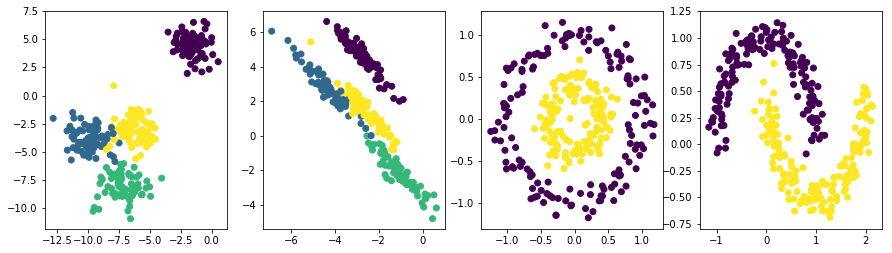

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_biclusters, make_circles
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

random_state = 1
k = 4
N = 300

X_blobs, y_blobs = make_blobs(N,centers=k,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_blobs, transformation)

X_circles, y_circles = make_circles(N,noise=0.1, factor=0.4, random_state=random_state)

X_moons, y_moons = make_moons(N, noise=0.1, random_state=random_state)

fig, axes = plt.subplots(1,4, figsize=(15,4))

axes[0].scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs)
axes[1].scatter(X_aniso[:,0], X_aniso[:,1], c=y_blobs)
axes[2].scatter(X_circles[:,0], X_circles[:,1], c=y_circles)
axes[3].scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

In [2]:
def dist(pt1, pt2):
    "Euclidean distance between two points"
    #note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi-yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt,ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i,ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis=0)
    return centers

Now we need an "initial guess" of cluster centers and we can apply the algorithm to a toy dataset:

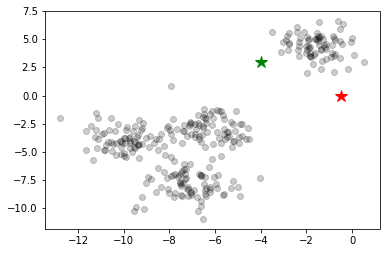

In [3]:
X = X_blobs
y = y_blobs

#cluster_centers = ([-0.5,0], [0.5,0])
cluster_centers = ([-0.5,0], [-4,3])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color='k', alpha=0.2)
colors = {0:'r', 1:'g', 2:'b',3:'m'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

#### How many clusters will the algorithm find? Approximately where do you expect the centers to be?

Run the cell below repeatedly to see how the algorithm converges. Re-run the cell above to re-start the algorithm.

[-6.33399468 -6.24628882]
[-6.12498003 -0.42339798]


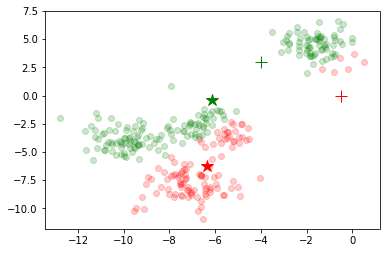

In [4]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='+', markersize='12', color=colors[i])
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[],[]]
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])
    

#### What will happen if this is applied to other datasets? How sensitive are answers to the initial guesses?

In practice it is more efficient to utilize the `scikit-learn` implementation of `KMeans`:

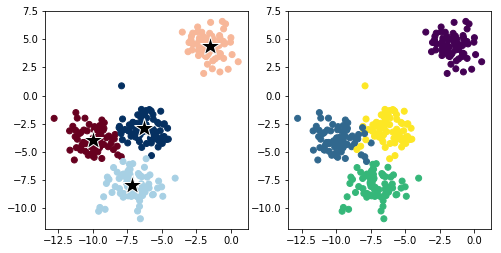

In [5]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, random_state=random_state)
model.fit(X)
y_predict = model.predict(X)
centers = model.cluster_centers_

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(X[:,0], X[:,1], c=y_predict, cmap='RdBu')
axes[1].scatter(X[:,0], X[:,1], c=y)
for center in centers:
    x_i = center[0]
    y_i = center[1]
    axes[0].plot(x_i, y_i, marker='*', color='k', mec='w', markersize=20)

### Vector quantization

"Vector quantization" is a common application of clustering algorithms. The k-means algorithms is utilized to identify clusters of similar vectors, then each vector is replaced with the centroid of its cluster. This is often used for data compression. First let's start with a 1D example:

(array([  3.,  25.,  44.,  38.,  71.,  40.,   5.,  15.,  44.,  15.]),
 array([-12.7907975, -11.4591162, -10.1274349,  -8.7957536,  -7.4640723,
         -6.132391 ,  -4.8007097,  -3.4690284,  -2.1373471,  -0.8056658,
          0.5260155]),
 <a list of 10 Patch objects>)

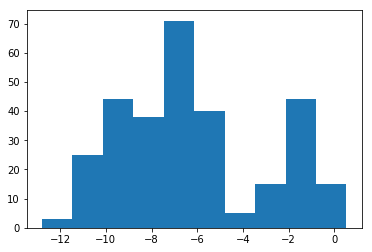

In [6]:
X_1d = X[:,0]

fig, ax = plt.subplots()
ax.hist(X_1d, bins=10)

This histogram is a "quantized" version of the original data. Instead of all 300 (or $N$) x, y values the data can now be represented with 10 (or $bins$) bin locations and 10 counts. This approximates the entire dataset with substantially less information!

Of course we can do better than this, since we know that some bins will be empty (or approximately empty). 

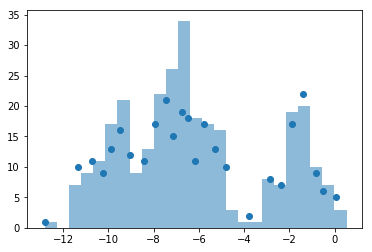

In [7]:
k = 25
model = KMeans(n_clusters=k, random_state=random_state)
X_1d_skl = X_1d.reshape(-1,1)
model.fit(X_1d_skl)
y_predict = model.predict(X_1d_skl)
centers = model.cluster_centers_
unique, counts = np.unique(y_predict, return_counts=True) #<- useful way to count occurences!

fig, ax = plt.subplots()
ax.hist(X_1d, bins=k, alpha=0.5)
ax.scatter(centers,counts)

We can see that k-means performs similarly to the histogram binning, though there are some differences based on initial guesses and the alignment of the bins\clusters with the data. This is a well-known issue with histograms an can be overcome with "kernel density estimation". This is beyond the scope of the lecture, but we will show it here for comparison:

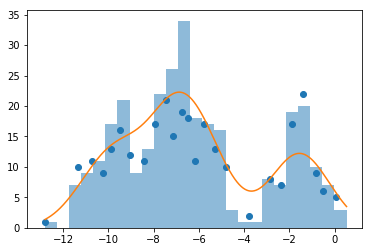

In [8]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(X_1d)
scale_factor = ((max(X_1d) - min(X_1d))/k)*len(X_1d)
xx = np.linspace(min(X_1d), max(X_1d), 1000)
ax.plot(xx, kde(xx)*scale_factor)
fig

Generally k-means tends to give a slightly better, or at least equally good, estimate of the underlying distribution. The issues with histograms only get worse when going to higher dimensions.

#### Consider a 3-dimensional dataset with 255 bins in each dimension. How many bins are needed to represent this space?

This example corresponds exactly to the RGB color pallette used by computers. We can use this test space to illustrate vector quantization in action. We will work with a sample image of the Atlanta skyline.

In [9]:
! pip install imageio

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Shape: (1703, 3397, 3)
Max value: 255
Min value: 0


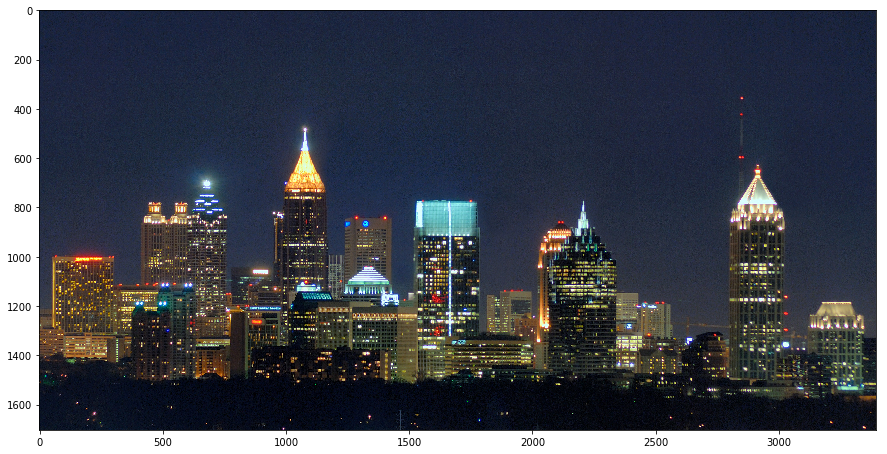

In [10]:
from imageio import imread

atl = imread("images/atlanta.jpg") #<-load the image
print('Shape:', atl.shape)
print('Max value:',atl.max())
print('Min value:', atl.min())

atl = np.array(atl, dtype=np.float64) / 255

fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(atl)

We need to recognize that this image is simply a list of 1703 $\times$ 3397 = 5785091 data points in the 3-dimensional RGB color space. We can re-shape the image into a list of 3D points:

(5785091, 3)
[ 0.08627451  0.12941176  0.2       ]


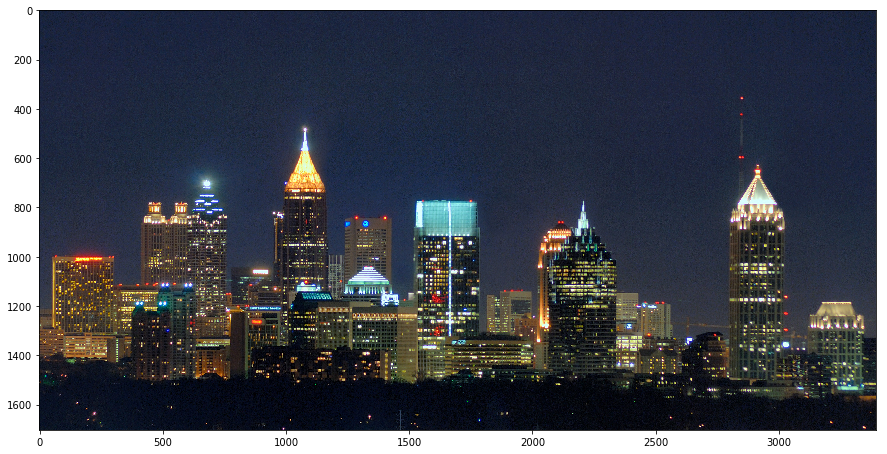

In [11]:
def deconstruct_image(img):
    n_x, n_y, rgb = img.shape
    N = n_x*n_y
    return img.reshape(N,rgb)

def reconstruct_image(points, n_x,n_y):
    N, rgb = points.shape
    return points.reshape(n_x,n_y,rgb)

n_x,n_y,rgb = atl.shape
img_X = deconstruct_image(atl)
print(img_X.shape)
print(img_X[0])

img = reconstruct_image(img_X, n_x,n_y)
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(img)

Lets see how many colors are in this image:

In [12]:
# This code block takes too long to run due to the image size! The answer is
"""
uniques = []
for pt in img_X:
    unique = True
    for pt_j in uniques:
        if (pt_j == pt).all():
            unique = False
    if unique == True:
        uniques.append(pt)
    if len(uniques) % 10000 == 0:
        print(len(uniques))
print(len(uniques))
"""

'\nuniques = []\nfor pt in img_X:\n    unique = True\n    for pt_j in uniques:\n        if (pt_j == pt).all():\n            unique = False\n    if unique == True:\n        uniques.append(pt)\n    if len(uniques) % 10000 == 0:\n        print(len(uniques))\nprint(len(uniques))\n'

Now the goal is to compress the image by identifying the characteristic colors, and approximating each pixel with on of the $N$ characteristic colors instead of one of the 16 million possible colors. Let's consider the case where $N=64$. We don't want to train the k-means model on all 500k data points, so we will take a sub-sample of 1000 to start with.

In [13]:
from sklearn.utils import shuffle

k = 8
N = 1000
model = KMeans(n_clusters=k, random_state=random_state)
X_train = shuffle(img_X, random_state=random_state)[:1000] #<- shuffle the points and take the first 1000 samples
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

#### How can we find the approximated colors for all the data points in the image?

In [14]:
labels = model.predict(img_X)
codebook = model.cluster_centers_

print(labels.shape)
print(codebook.shape)

(5785091,)
(8, 3)


Now we need to reconstruct the image, but this time we need to reconstruct the colors as well as the shape.

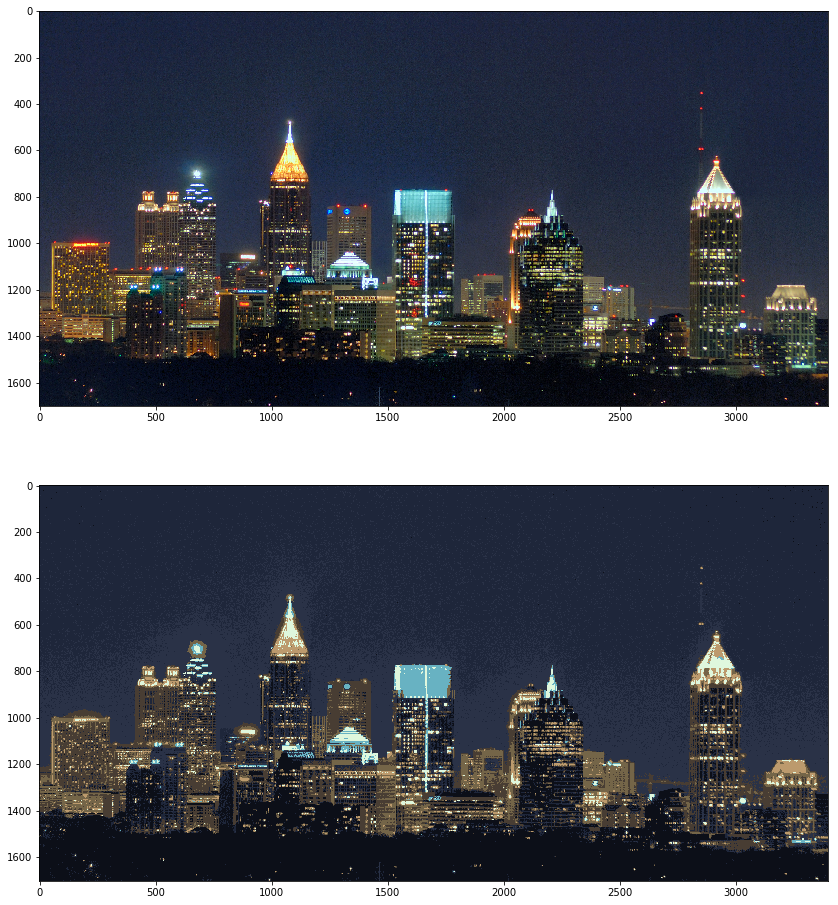

In [15]:
def reconstruct_quantized_image(labels, codebook, n_x,n_y):
    img = np.zeros((n_x,n_y,codebook.shape[1]))
    idx = 0
    for i in range(n_x):
        for j in range(n_y):
            img[i][j] = codebook[labels[idx]]
            idx += 1
    return img

compressed_img = reconstruct_quantized_image(labels, codebook, n_x, n_y)
fig, axes = plt.subplots(2,1,figsize=(15,16))
axes[0].imshow(atl)
axes[1].imshow(compressed_img)

#### How many total numbers are needed to represent the original image? How many for the compressed image?

### Gaussian mixture models

Gaussian mixture models, or GMM's, are another clustering approach based on expectation maximization. The approach is to model each cluster as a Gaussian distribution, and to model the entire dataset as a mixture of Gaussians. Mathematically:

$ P(\vec{x}) = \sum_k \phi_k \mathcal{N}(\vec{x}, \vec{\mu}, \vec{\sigma})$

where $\mathcal{N}$ is the normal distribution:

* one dimension: $N(x, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left( \frac{-(x-\mu)^2}{2 \sigma ^2} \right)$

* multi-dimensional: $N(\vec{x}, \vec{\mu}, \underline{\underline{\Sigma}}) = \frac{1}{(2 \pi |\underline{\underline{\Sigma}}|)} \exp \left( \frac{1}{2} (\vec{x} - \vec{\mu})^T \underline{\underline{\Sigma}}^{-1}  (\vec{x} - \vec{\mu}) \right)$

where $\underline{\underline{\Sigma}}$ is the covariance matrix.

#### Expectation step:

We can calculate the expected probability that a point $i$ is in a cluster $k$ with the following formula for a 1d Gaussian:

$\gamma_{ik} = \frac{\phi_k \mathcal{N}(\vec{x}_i, \vec{\mu}_k, \vec{\sigma}_k)}{\sum_j \phi_j \mathcal{N}(\vec{x}_i, \vec{\mu}_j, \vec{\sigma}_j)}$

#### Maximization step:

The parameters of the distributions can then be updated by calculating the maximum likelihood estimators for $\phi$, $\mu$, and $\sigma$, similar to the way these parameters would be estimated for a single distribution:

* $\phi_k = \sum_{i=1}^N \frac{\gamma_{ik}}{N}$
* $\mu_k = \frac{\sum_{i=1}^N \gamma_{ik} x_i}{\sum_{i=1}^N \gamma_{ik}} $
* $\sigma_k = \frac{\sum_{i=1}^N \gamma_{ik} (x_i - \mu_k)^2}{\sum_{i=1}^N \gamma_{ik}} $

These parameters are derived by maximizing $P(\vec{x})$ with respect to each parameter. The formulas for multi-dimensional Gaussians are derived in the same way but are more complex.

<img src="images/GMM.gif" width="500">

#### Question: In a 100-dimensional space with 10 clusters how many total numbers/parameters are needed to define the Gaussian mixture model?

Gaussian mixture models are much more flexible than k-means models. It turns out that k-means is equivalent to a GMM if the covariance matrix is constrained to a constant diagonal matrix. Let's see how GMM's perform for some of the earlier datasets:

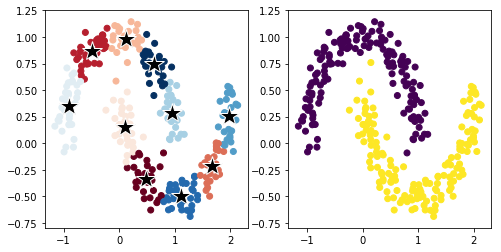

In [16]:
from sklearn.mixture import GaussianMixture

X = X_moons
y = y_moons

model = GaussianMixture(n_components=10, covariance_type='spherical') # diag, spherical
model.fit(X)
y_predict = model.predict(X)
centers = model.means_

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(X[:,0], X[:,1], c=y_predict, cmap='RdBu')
axes[1].scatter(X[:,0], X[:,1], c=y)
for center in centers:
    x_i = center[0]
    y_i = center[1]
    axes[0].plot(x_i, y_i, marker='*', color='k', mec='w', markersize=20)

#### How many clusters are needed to accurately represent the "moons" dataset?

## Density-based models

Density-based clustering algorithms consider local density of points and utilize this information to group points into clusters.

### Mean shift algorithm

The simplest density-based algorithm is the "mean shift" algorithm. This is similar to k-means in that we seek the centroid of each cluster. The difference is that in mean shift the number of clusters does not need to be specified. Instead a "window" is specified, and at each iteration the centroids are updated to centroid of all points in each window. Let's see how this works for a single point:

In [20]:
def get_distance(x1, x2):
    # we will use the numpy 2-norm to calculate Euclidean distance:
    return np.linalg.norm(x1-x2, 2) #<- the 2 is optional here since 2 is the default.

def get_nearby_points(x, x_list, r):
    # r is the radius
    dist_pairs = []
    for i,xi in enumerate(x_list):
        dist = get_distance(x, xi)
        dist_pairs.append([dist, i, xi]) #<- gives us the distance for each point
    in_window = [pt[-1] for pt in dist_pairs if pt[0] <= r]
    return in_window

def get_new_centroid(old_centroid, x_list, r):
    in_range = get_nearby_points(old_centroid, x_list, r)
    if len(in_range) == 0:
        new_centroid = old_centroid
    else:
        new_centroid = np.array(in_range).mean(axis=0)
    return new_centroid
        
    

Note the similarity to the kNN functions for prior lectures. It is a good idea to "abstract out" the distance function so that we could try other distance metrics easily.

Let's apply this to a single point in a dataset:

In [21]:
guess = [-1,1] #<- set an initial guess

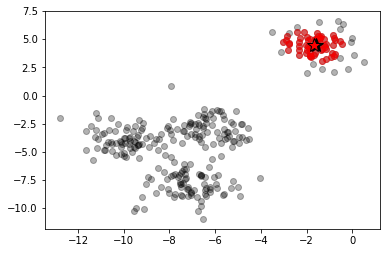

In [42]:
X = X_blobs
r = 1.5

nearby = get_nearby_points(guess, X, r)
nearby = np.array(nearby)
new = get_new_centroid(guess, X, r)

fig, ax = plt.subplots()
ax.plot(guess[0], guess[1], marker='*', color='k', markersize=15)
ax.scatter(X[:,0], X[:,1], color='k', alpha=0.3)
ax.scatter(nearby[:,0], nearby[:,1], color='r', alpha=0.5)
ax.plot(new[0], new[1], marker='*', color='r', markersize=15, mec='k')

guess = new

Re-run the block above to watch the point converge. You can play with the initial guess to see how it changes things.

#### What happens if the initial guess is very far away from a cluster?

We see that the mean shift algorithm causes an initial guess for a centroid to move toward a point of higher density. However, it isn't clear exactly how to get initial guesses. If we choose random points then some will have no points around them and not move. It also isn't clear how to decide how many initial guess points we should use.

The solution to this is to use each point of the dataset as an initial guess!

In [29]:
centroids = X

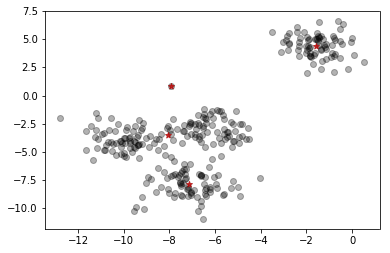

In [41]:
def mean_shift_iteration(x_list, r):
    centroids = []
    for centroid in x_list:
        new = get_new_centroid(centroid, x_list, r)
        centroids.append(new)
    return centroids

new_centroids = mean_shift_iteration(centroids, r)

news = np.array(new_centroids)
olds = np.array(centroids)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color='k', alpha=0.3)
ax.scatter(olds[:,0], olds[:,1], color='k', marker='*', alpha=0.5)
ax.scatter(news[:,0], news[:,1], color='r', marker='*', alpha=0.5)

centroids = new_centroids

To complete the algorithm we just need to iterate until the new centrods are the same as the old centroids, and assign points to the nearest centroid:

working 151.514943335
working 8.64956497063
working 9.55308280402
working 6.11811837576
working 1.58916318617
working 0.0299188049915


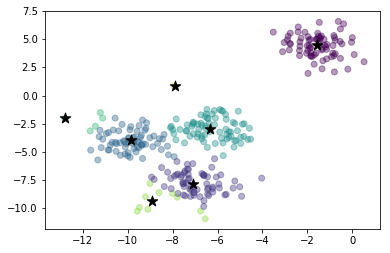

In [46]:
def mean_shift_clustering(x_list, r, tolerance=0.01):
    # tolerance will define when new and old centroids are the same.
    old_centroids = np.array(x_list)
    new_centroids = np.zeros(x_list.shape)
    delta = np.linalg.norm(old_centroids - new_centroids)
    while delta >= tolerance:
        print('working', delta)
        new_centroids = mean_shift_iteration(old_centroids, r)
        delta = np.linalg.norm(old_centroids - new_centroids)
        old_centroids = np.array(new_centroids)
        
    unique_centroids = []
    for centroid in new_centroids:
        unique = True
        for uc in unique_centroids:
            if np.linalg.norm(uc - centroid) <= tolerance:
                unique = False
        if unique == True:
            unique_centroids.append(centroid)
            
    labels = []
    for pt in x_list:
        min_dist = 1e99
        for j,centroid in enumerate(unique_centroids):
            if get_distance(pt,centroid) < min_dist:
                label = j
                min_dist = get_distance(pt,centroid)
        labels.append(label)
            
    return labels, np.array(unique_centroids)

r = 1.5
labels, centroids = mean_shift_clustering(X, r)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', alpha=0.4)
ax.scatter(centroids[:,0], centroids[:,1], marker='*', s=120, color='k')

#### Why did the algorithm only find 3 clusters here? How could we modify it to find more?

### DBSCAN

The DBSCAN algorithm also uses a local sliding window similar to mean shift, but instead of defining clusters by centroids it defines the cluster by whether or not a point falls within the sliding window. We will not go through the algorithm in detail, but the general steps are:

1) Start with a random point and find its neigbhors within distance $r$.

2) If there are a sufficient number of neigbhors (defined by a minimum points argument) then the clustering process starts. If not then the point is labeled as noise and a new point is selected until the clustering process starts.

3) The neighbors within a distance $r$ are added to the cluster.

4) The nearest neighbor is selected as the next point, and the same process is repeated until all points within distance $r$ of any point within a cluster are defined as being part of that cluster.

5) Once a cluster has finished, a new point is selected and a new cluster is started. The process is repeated until all points have been assigned to a cluster or labeled as noise.

The key hyperparameters are:
    * r - the radius to include in a cluster
    * min_samples - the minimum number of samples within a radius of $\epsilon$ such that a point is not considered noise.
    
The following animation illustrates how the DBSCAN algorithm works:

<img src="images/DBSCAN.gif" width="500">

The main advantage of DBSCAN is that it can find clusters defined by highly non-linear boundaries, unlike k-means, mean shift, or even GMM's. Let's see how the `scikit-learn` implementation works:

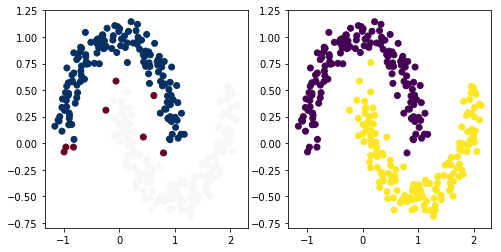

In [55]:
from sklearn.cluster import DBSCAN

X = X_moons
y = y_moons

model = DBSCAN(eps=0.15, min_samples=4)
y_predict = model.fit_predict(X)

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].scatter(X[:,0], X[:,1], c=y_predict, cmap='RdBu')
axes[1].scatter(X[:,0], X[:,1], c=y)

Note that the clustering can be very sensitive to the hyperparameters! These hyperparameters will be related to the density of points, so you may be able to get a good guess based on intuition about the data or by looking at the data. However, some tuning is nearly always necessary.

#### What happens if we want to predict the cluster of a new point?

## Hierarchical models

The final type of clustering we will discuss are "hierarchical" models. These models construct linkages between different points and use distance cutoffs to assign clusters. Examining the hierarchy of points is a useful way to get insight into the structure of a high-dimensional dataset without dimensional reduction. The downside is that it can be rather slow, since the algorithms scale as $N^3$. However, for the relatively small sizes of datasets typically encountered in engineering it is usually feasible to construct these hierarchies.

### Dendrograms

A "dendrogram" is a graphical representation of the distances between different points in some high-dimensional space. One intuitive but qualitative example of a dendrogram are the [species trees](https://www.instituteofcaninebiology.org/how-to-read-a-dendrogram.html) commonly used in biology:

<img src="images/bio_dendrogram.png" width="500">

We can see that it is possible to create different "clusters" of species based on different defining characteristics. By choosing more or less specific "cutoffs" we could create a few large clusters or many small clusters. The idea is similar for data sets. Let's see how it looks for some of our examples.

In [75]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = X_moons

Z = linkage(X, method='single')

Lets take a closer look at the "linkage" output:

In [76]:
print('X shape: {}'.format(X.shape))
print('Z shape: {}'.format(Z.shape))
print('Z[0]:', Z[150])

X shape: (300, 2)
Z shape: (299, 4)
Z[0]: [  1.68000000e+02   4.49000000e+02   6.02290036e-02   5.00000000e+00]


The "linkage" output has 4 members. Each entry corresponds to the formation of a new cluster from smaller clusters, hence there are (n-1) entries (since the first entry involves 2 points, and each iteration adds one more point).

* the first two entries are the index of the two points/clusters that are being combined (point 185 and 270)
* the third entry is the distance between these clusters (0.0095)
* the fourth entry is the total number of points in the new cluster (2 in this case)

Note that we passed a "method" argument into the linkage. This describes the method that is used to calculate the distance between two clusters that have multiple points. There are more details available [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), but a very qualitative descripton of some of the options:

* `single`: take the minimum distance between any two points in the two clusters
* `complete`: take the maximum distance between any two points in the two clusters
* `average`: use an average of distances between points in the two clusters
* `weighted`: weight distances differently between the agglomerated cluster and one being added
* `centriod`: use the distance between cluster centroids
* `ward`: use the distance that minimizes the variance between the clusters

So, which one should we choose? This is where we can use the "cophenetic coefficient", which measures the ratio of the distance in "linkage" space to the distance in the high-dimensional space.

In [77]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Dij = pdist(X, metric='minkowski', p=10)
for method in ['single','complete','average','weighted','centroid','ward']:
    Z = linkage(X,method=method)
    C, coph_dists = cophenet(Z,Dij)
    print('cophenetic coefficient of {}: {}'.format(method, C))

cophenetic coefficient of single: 0.5228240054143481
cophenetic coefficient of complete: 0.6791523858084797
cophenetic coefficient of average: 0.6958146132802444
cophenetic coefficient of weighted: 0.6836917711029409
cophenetic coefficient of centroid: 0.6923259064515702
cophenetic coefficient of ward: 0.6901872626742471


#### Which distance metric do you recommend? Does this make sense based on the structure of the data?

The `dendrogram` function is a visual representation of this "linkage" structure. The "color threshold" tells the dendrogram a distance (y-axis value) below which to identify separate branches of the dendrogram as different colors.

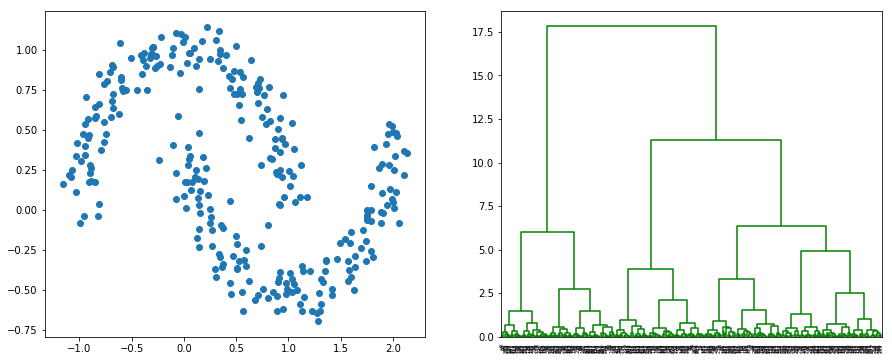

In [78]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
Z = linkage(X,method='ward')
dendrogram(Z, color_threshold=20, ax=axes[1])
axes[0].scatter(X[:,0],X[:,1])

#### What will happen if we change the linkage mode?

Sometimes it is easier to not show every single datapoint, and truncate the dendrogram:

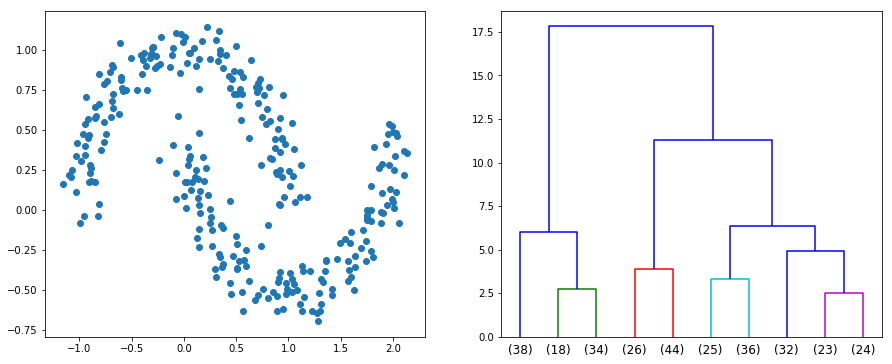

In [79]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
dendrogram(Z, color_threshold=4, truncate_mode='lastp', p=10, ax=axes[1])
axes[0].scatter(X[:,0],X[:,1])

### Agglomerative hierarchical clustering

Agglomerative clustering is easy to understand once the "linkage" structure makes sense. The number of clusters can be defined either explicitly (move up the tree until there are 'k' clusters) or implicitly (provide a linkage distance that defines separate clusters).

The following animations illustrates this nicely:

<img src="images/agglomerative.gif" width="700">

The mechanics of doing this can be a little tricky, but luckily there are built-in functions to help:

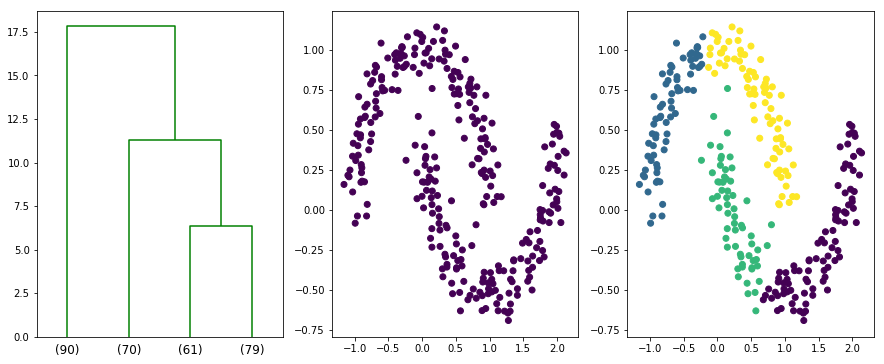

In [83]:
from scipy.cluster.hierarchy import fcluster

max_d = 20
k = 4

clusters_dist = fcluster(Z, max_d, criterion='distance')
clusters_k = fcluster(Z, k, criterion='maxclust')

fig, axes = plt.subplots(1,3, figsize=(15,6))
dendrogram(Z, color_threshold=max_d, truncate_mode='lastp', p=k, ax=axes[0])
axes[1].scatter(X[:,0],X[:,1],c=clusters_dist)
axes[2].scatter(X[:,0],X[:,1],c=clusters_k)

There are options for determining the cutoffs automatically, but none of them are great! The most common is the inconsistency method, which monitors for "jumps" in the distance:

* $I = \frac{h-avg}{std}$
    - $h$: merge height of cluster (length in y-directon on dendrogram)
    - $avg$: average height of last $d$ merges
    - $std$: standard deviation of last $d$ merges
    
If $I >= t$ where t is a specified threshold then this will be used as the cutoff. Let's see how it performs:

Number of clusters: 21


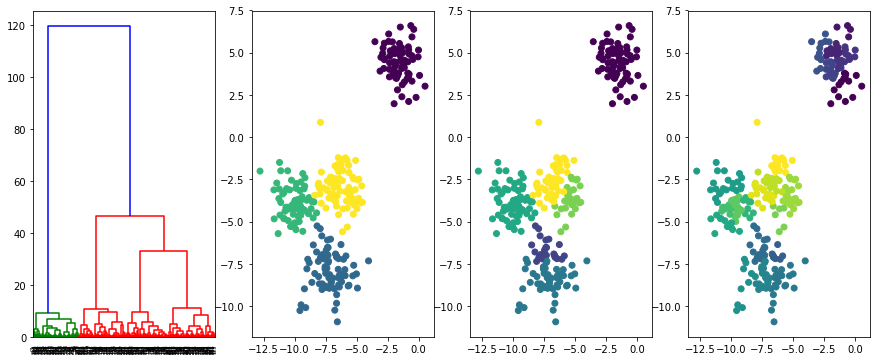

In [74]:
I_cutoff = 3.5
clusters_I = fcluster(Z, I_cutoff, criterion='inconsistent', depth=10)

fig, axes = plt.subplots(1,4, figsize=(15,6))
dendrogram(Z, ax=axes[0])
axes[1].scatter(X[:,0],X[:,1],c=clusters_dist)
axes[2].scatter(X[:,0],X[:,1],c=clusters_k)
axes[3].scatter(X[:,0],X[:,1],c=clusters_I)
print('Number of clusters:', max(clusters_I))

#### How many hyperparameters are needed for the inconsistency method? Would you recommend this approach?

## Conclusions

* Clustering algorithms are **unsupervised**.
* Clustering is used for **exploratory data analysis**.
* Assessing the accuracy of clustering methods is challenging if the labels are not known.
* Distance metrics can make a big difference in how clustering algorithms perform.
* Three types of algorithms were discussed:
    -  Expectation Maximization
    -  Density-based
    -  Hierarchical
* Some considerations for choosing an algorithm:
    -  Is the number of clusters known?
    -  Are data points expected to belong to a single cluster, or is **mixed membership** expected?
    -  Is noise expected in the data?
* Clustering algorithms are useful for:
    -  Data compression (vector quantization)
    -  Searching data
    -  Grouping data
    -  Establishing intuition
* When clustering data it is a good idea to try many approaches with difference distance/error metrics to get a feel for which factors are important. 

* If possible, visualizing the data directly can provide substantial intuition about which methods will perform best.
* Dendrograms are a useful way to indirectly visualize data in a high-dimensional space, and the difference between a dendrogram and a direct measure of distance can be quantified with the **cophenetic coefficient**.

## Further reading

* [Evaluation of clustering algorithms](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
* [Overview of 5 key clustering algorithms](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)
* [Python Data Science Handbook: k-Means](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
* [Python Data Science Handbook: GMM](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)
* [GMM formulas](https://brilliant.org/wiki/gaussian-mixture-model/)
* [Color quantization example](http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)
* [Dendrogram and hierarchical clustering tutorial](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)
* Hastie Ch. 13 (pg. 459)